In [1]:
!nvidia-smi

Sun Dec  3 15:55:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.__version__

'2.14.0'

Here we can see how each image have difference dimensions

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

path = r'/content/drive/MyDrive/Colab Notebooks/train/Type_1'
images = []

for filename in os.listdir(path):
    img = cv2.imread(os.path.join(path, filename))
    if img is not None:
        height, width, channels = img.shape
        resized_img = cv2.resize(img, (224, 224)) # Resize the image
        images.append(resized_img)
        print(f"File: {filename}")
        print(f"Size (height x width): {height} x {width}")
        print(f"Dimension (channels): {channels}\n")

File: 1023.jpg
Size (height x width): 4128 x 3096
Dimension (channels): 3

File: 1013.jpg
Size (height x width): 3264 x 2448
Dimension (channels): 3

File: 1014.jpg
Size (height x width): 4128 x 3096
Dimension (channels): 3

File: 1026.jpg
Size (height x width): 4128 x 3096
Dimension (channels): 3

File: 1024.jpg
Size (height x width): 3264 x 2448
Dimension (channels): 3

File: 102.jpg
Size (height x width): 3264 x 2448
Dimension (channels): 3

File: 10.jpg
Size (height x width): 4128 x 3096
Dimension (channels): 3

File: 1019.jpg
Size (height x width): 3264 x 2448
Dimension (channels): 3

File: 0.jpg
Size (height x width): 3264 x 2448
Dimension (channels): 3

File: 104.jpg
Size (height x width): 4128 x 3096
Dimension (channels): 3

File: 1071.jpg
Size (height x width): 3264 x 2448
Dimension (channels): 3

File: 1040.jpg
Size (height x width): 3264 x 2448
Dimension (channels): 3

File: 1061.jpg
Size (height x width): 3264 x 2448
Dimension (channels): 3

File: 1100.jpg
Size (height x wi

KeyboardInterrupt: ignored

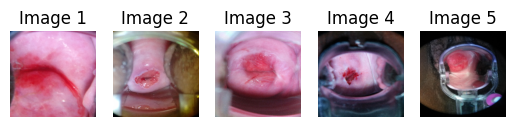

In [4]:
num_images_to_display = 5

for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)) # Convert color from BGR to RGB for proper visualization
    plt.axis('off')
    plt.title(f"Image {i+1}")

plt.show()

In [5]:
from glob import glob

# Assuming /content/DataSet/train/ contains folders like 'class1', 'class2', etc.
folders = glob('/content/drive/MyDrive/Colab Notebooks/train/*')

# 'folders' will be a list of paths to the subdirectories within /content/DataSet/train/
folders


['/content/drive/MyDrive/Colab Notebooks/train/Type_3',
 '/content/drive/MyDrive/Colab Notebooks/train/Type_1',
 '/content/drive/MyDrive/Colab Notebooks/train/Type_2']

In [6]:
import pandas as pd
from glob import glob
basepath = '/content/drive/MyDrive/Colab Notebooks/train/'

train_cervix_images = []

for path in sorted(glob(basepath + "*")):
    cervix_type = path.split("/")[-1]
    cervix_images = sorted(glob(basepath + cervix_type + "/*"))
    train_cervix_images = train_cervix_images + cervix_images

train_cervix_images = pd.DataFrame({'imagepath': train_cervix_images})
train_cervix_images['filetype'] = train_cervix_images.apply(lambda row: row.imagepath.split(".")[-1], axis=1)
train_cervix_images['type'] = train_cervix_images.apply(lambda row: row.imagepath.split("/")[-2], axis=1)
train_cervix_images.tail()

,imagepath,filetype,type
1476,/content/drive/MyDrive/Colab Notebooks/train/T...,jpg,Type_3
1477,/content/drive/MyDrive/Colab Notebooks/train/T...,jpg,Type_3
1478,/content/drive/MyDrive/Colab Notebooks/train/T...,jpg,Type_3
1479,/content/drive/MyDrive/Colab Notebooks/train/T...,jpg,Type_3
1480,/content/drive/MyDrive/Colab Notebooks/train/T...,jpg,Type_3


In [7]:
#ere the total no of trianing dataset is shown
train_cervix_images.shape

(1481, 3)

Text(0.5, 0, 'training size fraction')

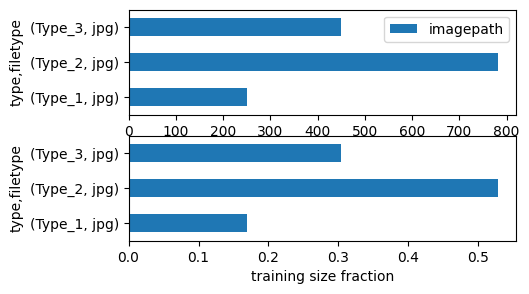

In [8]:
type_aggregation = train_cervix_images.groupby(['type', 'filetype']).agg('count')
type_aggregation_p = type_aggregation.apply(lambda row: 1.0*row['imagepath']/train_cervix_images.shape[0], axis=1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 3))

type_aggregation.plot.barh(ax=axes[0])
axes[0].set_xlabel("image count")
type_aggregation_p.plot.barh(ax=axes[1])
axes[1].set_xlabel("training size fraction")

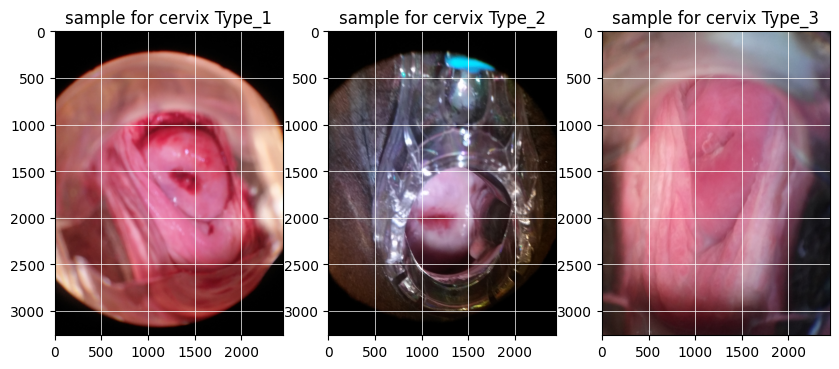

In [9]:
fig = plt.figure(figsize=(10,4))

i = 1
for t in train_cervix_images['type'].unique():
    ax = fig.add_subplot(1,3,i)
    i+=1
    f = train_cervix_images[train_cervix_images['type'] == t]['imagepath'].values[0]
    plt.imshow(plt.imread(f))
    plt.grid(True, color='white', linestyle='-', linewidth=0.5)
    plt.title('sample for cervix {}'.format(t))


## **Image dimensions**

Now, in order to get an idea of how many different shapes of images by class there are, lets have a look at. To reduce runtime, take only a subsample per class.

In [10]:
from collections import defaultdict

images = defaultdict(list)

for t in train_cervix_images['type'].unique():
    sample_counter = 0
    for _, row in train_cervix_images[train_cervix_images['type'] == t].iterrows():
        #print('reading image {}'.format(row.imagepath))
        try:
            img = cv2.imread(row.imagepath)
            sample_counter +=1
            images[t].append(img)
        except:
            print('image read failed for {}'.format(row.imagepath))
        if sample_counter > 35:
            break

In [11]:
len(images)

3

In [12]:
dfs = []
for t in train_cervix_images['type'].unique():
    t_ = pd.DataFrame(
        {
            'nrows': list(map(lambda i: i.shape[0], images[t])),
            'ncols': list(map(lambda i: i.shape[1], images[t])),
            'nchans': list(map(lambda i: i.shape[2], images[t])),
            'type': t
        }
    )
    dfs.append(t_)

shapes_df = pd.concat(dfs, axis=0)
shapes_df_grouped = shapes_df.groupby(by=['nchans', 'ncols', 'nrows', 'type']).size().reset_index().sort_values(['type', 0], ascending=False)
shapes_df_grouped   #we can see all the images in our sample has 3 channels

,nchans,ncols,nrows,type,0
3,3,2448,3264,Type_3,28
6,3,3096,4128,Type_3,7
7,3,3264,2448,Type_3,1
5,3,3096,4128,Type_2,18
2,3,2448,3264,Type_2,17
8,3,4128,3096,Type_2,1
1,3,2448,3264,Type_1,18
4,3,3096,4128,Type_1,17
0,3,2322,4128,Type_1,1


In [13]:
dfs

[    nrows  ncols  nchans    type
 0    3264   2448       3  Type_1
 1    4128   3096       3  Type_1
 2    3264   2448       3  Type_1
 3    4128   3096       3  Type_1
 4    3264   2448       3  Type_1
 5    3264   2448       3  Type_1
 6    4128   3096       3  Type_1
 7    3264   2448       3  Type_1
 8    4128   3096       3  Type_1
 9    4128   2322       3  Type_1
 10   4128   3096       3  Type_1
 11   4128   3096       3  Type_1
 12   3264   2448       3  Type_1
 13   3264   2448       3  Type_1
 14   4128   3096       3  Type_1
 15   3264   2448       3  Type_1
 16   3264   2448       3  Type_1
 17   3264   2448       3  Type_1
 18   4128   3096       3  Type_1
 19   3264   2448       3  Type_1
 20   3264   2448       3  Type_1
 21   3264   2448       3  Type_1
 22   3264   2448       3  Type_1
 23   4128   3096       3  Type_1
 24   4128   3096       3  Type_1
 25   4128   3096       3  Type_1
 26   4128   3096       3  Type_1
 27   4128   3096       3  Type_1
 28   4128   3

Now lets build a barplot to get an idea of the distribution of image dimensions by cervix type.

<Axes: xlabel='count', ylabel='size_with_type'>

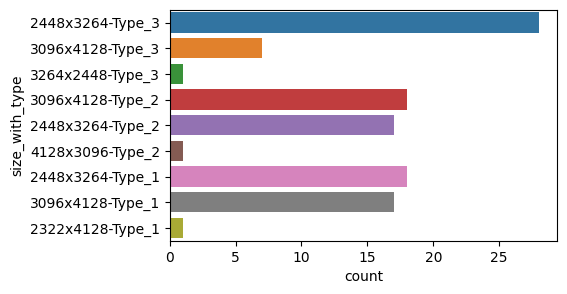

In [14]:
import seaborn as sns
shapes_df_grouped['size_with_type'] = shapes_df_grouped.apply(lambda row: '{}x{}-{}'.format(row.ncols, row.nrows, row.type), axis=1)
shapes_df_grouped = shapes_df_grouped.set_index(shapes_df_grouped['size_with_type'].values)
shapes_df_grouped['count'] = shapes_df_grouped[[0]]

plt.figure(figsize=(5,3))
#shapes_df_grouped['count'].plot.barh(figsize=(10,8))
sns.barplot(x="count", y="size_with_type", data=shapes_df_grouped)

## **TSNE Embedding**
##### t-SNE is a dimensionality reduction technique used for visualizing high-dimensional data in a lower-dimensional space (commonly 2D or 3D). It's primarily employed as a tool for exploratory data analysis and visualization rather than a method for augmenting the training data.

#####We will now take all of the sample images, rescale them & convert them to grayscale. This will result in a matrix, where each row are all flattened pixel for the grayscale images.

The original images have, as we have seen earlier, quite a high resolution, so scaling them down to 100 x 100 is resulting in a great loss of information, so the embedding to two dimensions is likely not going to have a good structure where we can separate visually by cervical cancer types. Also, we are giving only very few images per class that TSNE can work with to find a good, distance preserving, embedding.

Reducing the dimensionality and using grayscale images may help mitigate this issue.

**Loss of Information:**

Although reducing the resolution and converting to grayscale results in a loss of information, in some cases, this trade-off is acceptable, especially when the goal is to visualize and explore the dataset's structure rather than precisely classify images.

In [15]:
def transform_image(img, rescaled_dim, to_gray=False):
    resized = cv2.resize(img, (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR)

    if to_gray:
        resized = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY).astype('float')
    else:
        resized = resized.astype('float')

    normalized = cv2.normalize(resized, None, 0.0, 1.0, cv2.NORM_MINMAX)
    timg = normalized.reshape(1, np.prod(normalized.shape))

    return timg/np.linalg.norm(timg) #The L2 norm (Euclidean norm) of the flattened image is computed using np.linalg.norm.

rescaled_dim = 100

all_images = []
all_image_types = []

for t in train_cervix_images['type'].unique():
    all_images = all_images + images[t]
    all_image_types = all_image_types + len(images[t])*[t]
# - normalize each uint8 image to the value interval [0, 1] as float image
# - rgb to gray
# - downsample image to rescaled_dim X rescaled_dim
# - L2 norm of each sample = 1
gray_all_images_as_vecs = [transform_image(img, rescaled_dim) for img in all_images]

gray_imgs_mat = np.array(gray_all_images_as_vecs).squeeze()
all_image_types = np.array(all_image_types)
gray_imgs_mat.shape, all_image_types.shape  #output will show the dataset contains 108 images, each represented as a 1D array of length 30000 after transformation.

((108, 30000), (108,))

####3D t-SNE with cervix indicators
#####Now let's project the 100x100x3 images to three dimensions to check for low dimensional patterns.

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(    #tsne will store the coordinates of the data points of each image in 3d space
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
).fit_transform(gray_imgs_mat)

#KL divergence is used to measure the difference between the original high-dimensional space
#and the lower-dimensional space created by the t-SNE algorithm.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 108 samples in 0.003s...
[t-SNE] Computed neighbors for 108 samples in 0.154s...
[t-SNE] Computed conditional probabilities for sample 108 / 108
[t-SNE] Mean sigma: 0.222224
[t-SNE] Computed conditional probabilities in 0.018s
[t-SNE] Iteration 50: error = 79.6910553, gradient norm = 0.2611145 (50 iterations in 0.072s)
[t-SNE] Iteration 100: error = 93.9823456, gradient norm = 0.5835717 (50 iterations in 0.055s)
[t-SNE] Iteration 150: error = 108.9197083, gradient norm = 0.4173564 (50 iterations in 0.052s)
[t-SNE] Iteration 200: error = 116.7009888, gradient norm = 0.0959415 (50 iterations in 0.050s)
[t-SNE] Iteration 250: error = 120.1287994, gradient norm = 0.1222599 (50 iterations in 0.057s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 120.128799
[t-SNE] Iteration 300: error = 2.9895830, gradient norm = 0.0086968 (50 iterations in 0.052s)
[t-SNE] Iteration 350: error = 2.4548297, gradient norm = 0.00700

In [17]:
from sklearn import preprocessing
import plotly.graph_objects as go
import plotly.offline as py


trace1 = go.Scatter3d(
    x=tsne[:, 0],
    y=tsne[:, 1],
    z=tsne[:, 2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color=preprocessing.LabelEncoder().fit_transform(all_image_types),
        colorscale='Portland',
        colorbar=dict(title='cervix types'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.9
    )
)

data = [trace1]

layout = dict(
    height=800,
    width=800,
    title='3D embedding of images',
    scene=dict(
        xaxis=dict(gridcolor='rgba(0, 0, 0, 0.2)', gridwidth=2),  # Adjust x-axis grid properties
        yaxis=dict(gridcolor='rgba(0, 0, 0, 0.2)', gridwidth=2),  # Adjust y-axis grid properties
        zaxis=dict(gridcolor='rgba(0, 0, 0, 0.2)', gridwidth=2),  # Adjust z-axis grid properties
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='TSNE_Embedding')


#####We can clearly see that there is a big heterogeneous cluster and a few quite distant outliers.

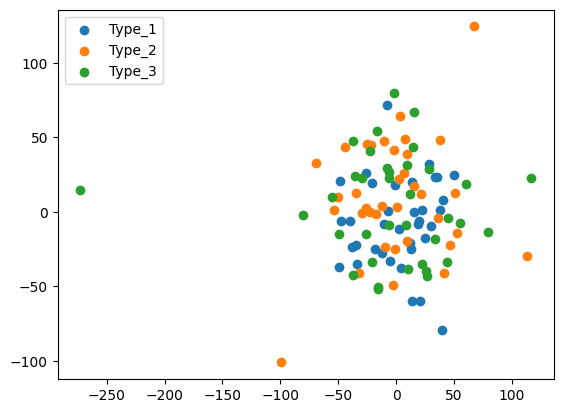

In [18]:

for t in train_cervix_images['type'].unique():
    tsne_t = tsne[np.where(all_image_types == t), :][0]
    plt.scatter(tsne_t[:, 0], tsne_t[:, 1])
plt.legend(train_cervix_images['type'].unique())

##**Image clustering with TSNE embedding**
#####Let us now use the compressed images and the distance-preserving transformation of TSNE to get an understanding of what image clusters there are.

For that we will use matplotlib to replace the previously red, green and blue points with the actual images that were input to the TSNE transformation.

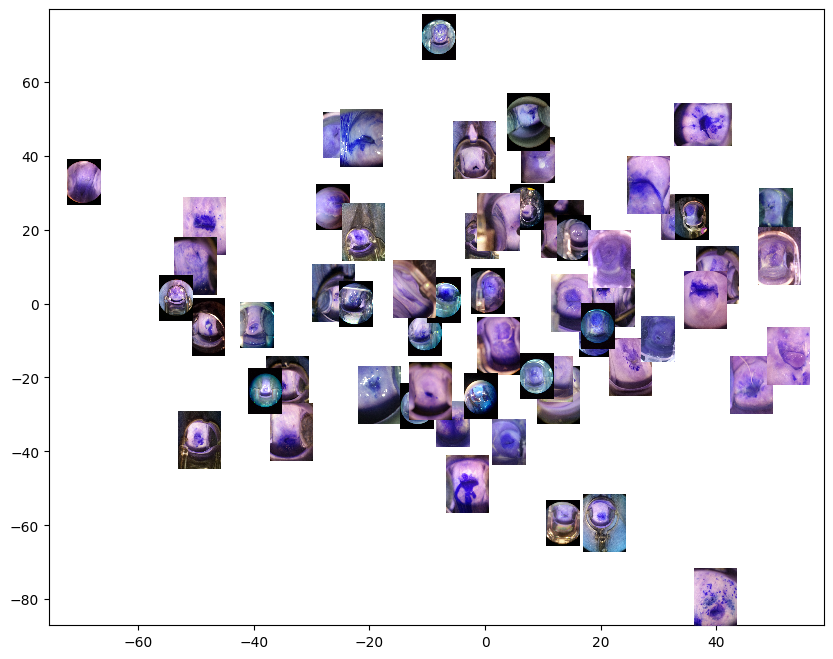

In [19]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def imscatter(x, y, images, ax=None, zoom=0.01):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    #return artists

nimgs = 60
plt.figure(figsize=(10,8))
imscatter(tsne[0:nimgs,0], tsne[0:nimgs,1], all_images[0:nimgs])